<a href="https://colab.research.google.com/github/RentoYabuki06/bio-python-practice/blob/main/dna_translate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
!pip install biopython

## Step 1: 複数のDNA配列を翻訳してみる
- DNA配列のリストを作成し、それぞれタンパク質配列に翻訳
- 翻訳された配列から、開始コドンやストップコドンの位置なども観察

In [11]:
from Bio.Seq import Seq

# 複数のDNA配列を準備
sequences = ["ATGGCC", "ATGTTTAAAGGG", "ATGCGAATAG"]

# 各配列を翻訳
for seq in sequences:
    s = Seq(seq)
    print(f"{seq} -> {s.translate()}")

ATGGCC -> MA
ATGTTTAAAGGG -> MFKG
ATGCGAATAG -> MRI


/usr/local/lib/python3.11/dist-packages/Bio/Seq.py:2879: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


## Step 2: 塩基の頻度とGC含量を計算する
- DNA配列に含まれるA/T/G/Cの数を数える
- GC含量（G+Cの割合）はゲノムの性質を示す重要な指標

In [12]:
from collections import Counter

# DNA配列
seq = "ATGCGTACCTGA"

# 出現頻度のカウント
counts = Counter(seq)

# GC含量の計算
gc_content = (counts["G"] + counts["C"]) / len(seq) * 100

print("塩基カウント:", counts)
print("GC含量: {:.2f}%".format(gc_content))

塩基カウント: Counter({'A': 3, 'T': 3, 'G': 3, 'C': 3})
GC含量: 50.00%



# 🧬 FASTA形式とは？

FASTA形式は、DNA・RNA・タンパク質などの配列データを記述するための標準的なテキスト形式

## 📄 構成

- 1行目は `>` で始まり、**配列IDや説明文**を含む
- 2行目以降に**実際の配列データ**（A/T/G/C や アミノ酸1文字コード）が続く

## 🧾 例（DNA配列）

```
> seq1 Homo sapiens mitochondria COX1 gene
> ATGGCACCTGACTGACTTCCGAGGAGGAGGCGGAGGACCTTGAACCC
```

## ✅ 注意点
- 拡張子は `.fasta`, `.fa`, `.fna`, `.faa` など
- 複数配列を1ファイルにまとめることも可能（マルチFASTA）
- Biopythonなどのツールで扱いやすい



[NCBI](https://www.ncbi.nlm.nih.gov/nuccore/?term=BRCA1%5BGene%5D+AND+Homo+sapiens%5BOrganism%5D)などから特定の遺伝子配列をダウンロード可能◎

---


# Step 3: FASTAファイルから配列を読み込む
- 実際の生物データ（例：ヒトミトコンドリア）を使います
- `.fasta`形式のファイルをColabにアップロードして読み込む

In [18]:
from Bio import SeqIO
import urllib.request

# GitHubのRawファイルURL（自分のリポジトリに応じて変更してください）
url = "https://raw.githubusercontent.com/RentoYabuki06/bio-python-practice/main/sequence.fasta"

# 一時ファイルにダウンロードして保存
urllib.request.urlretrieve(url, "example.fasta")

# Biopythonで読み込む
for record in SeqIO.parse("example.fasta", "fasta"):
    print("ID:", record.id)
    print("配列長:", len(record.seq))
    print("配列（最初の50塩基）:", record.seq[:50])

ID: NG_005905.2
配列長: 193689
配列（最初の50塩基）: TGTGTGTATGAAGTTAACTTCAAAGCAAGCTTCCTGTGCTGAGGGGGTGG


# Step 4: 自作コドン表で翻訳してみる
- 辞書（dict）を使ってDNA配列をアミノ酸に翻訳
- 標準の翻訳とは違って、カスタマイズ可能

In [20]:
codon_table = {
    'ATG': 'M', 'GCC': 'A', 'TAA': '*', 'GCG': 'A', 'TTT': 'F', 'AAA': 'K', 'GGG': 'G'
}

seq = "ATGGCCGCGTAA"
protein = ''.join([codon_table.get(seq[i:i+3], '-') for i in range(0, len(seq), 3)])
print("Protein:", protein)

Protein: MAA*


# Step 5: Matplotlibで塩基頻度を可視化する
- DNA配列中の塩基分布をグラフで表示
- 論文風の図作成にも役立ちます

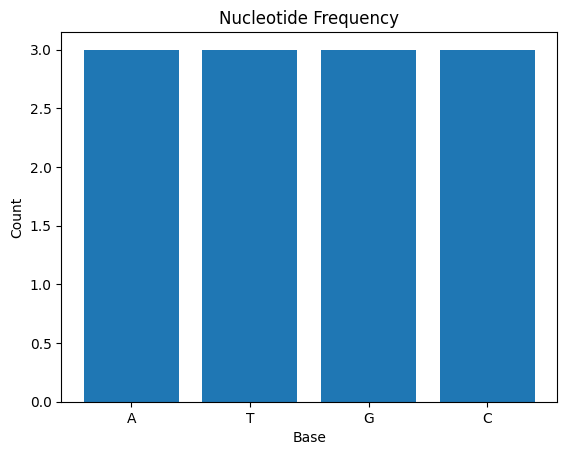

In [21]:
import matplotlib.pyplot as plt

# DNA配列
seq = "ATGCGTACCTGA"

# 塩基の出現回数をカウント
counts = Counter(seq)

# 棒グラフで可視化
plt.bar(counts.keys(), counts.values())
plt.title("Nucleotide Frequency")
plt.xlabel("Base")
plt.ylabel("Count")
plt.show()

## ① ORF（オープンリーディングフレーム）の検出
ORFとは、DNA配列中で開始コドン（ATG）から始まり、
終止コドン（TAA, TAG, TGA）のいずれかで終わる連続した翻訳可能領域です。
ORFを検出することで、どの領域がタンパク質へ翻訳されうるかを知ることができます。
生物の遺伝子アノテーションや新規遺伝子の予測にも使われる重要な解析です。

In [22]:
def find_orfs(seq, min_length=100):
    seq = str(seq)
    orfs = []
    for i in range(0, len(seq)-3, 3):
        codon = seq[i:i+3]
        if codon == "ATG":  # 開始コドン
            for j in range(i+3, len(seq)-3, 3):
                stop = seq[j:j+3]
                if stop in ["TAA", "TAG", "TGA"]:
                    orf = seq[i:j+3]
                    if len(orf) >= min_length:
                        orfs.append(orf)
                    break
    return orfs

# 使用例
orfs = find_orfs(record.seq)
print(f"{len(orfs)}個のORFを検出")
print(f"最初のORFの長さ: {len(orfs[0])} 塩基")



190個のORFを検出
最初のORFの長さ: 183 塩基


## ② コドン使用頻度の可視化
コドンは3塩基ごとの単位で、アミノ酸に翻訳される遺伝コードです。
同じアミノ酸をコードする複数のコドンが存在しますが、
生物によって「好まれるコドン」が偏っていることがあります（コドンバイアス）。
この分析は、発現最適化や遺伝子合成の設計にも役立ちます。

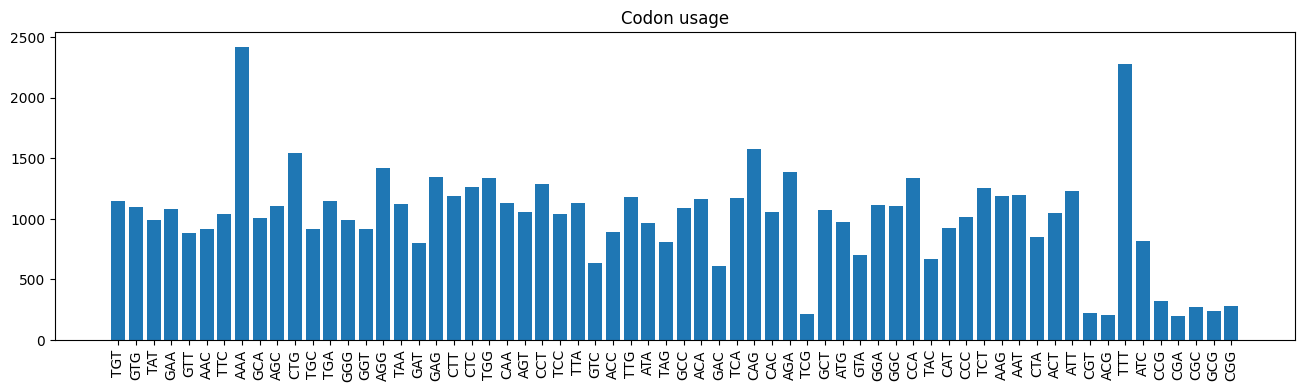

In [23]:
from collections import defaultdict
from Bio.Data import CodonTable

# コドン→アミノ酸の辞書
standard_table = CodonTable.unambiguous_dna_by_name["Standard"]
codons = [a + b + c for a in "ATGC" for b in "ATGC" for c in "ATGC"]

# カウント初期化
codon_count = defaultdict(int)

# 配列中のコドン頻度
for i in range(0, len(record.seq)-2, 3):
    codon = str(record.seq[i:i+3])
    if codon in codons:
        codon_count[codon] += 1

# 可視化
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 4))
plt.bar(codon_count.keys(), codon_count.values())
plt.xticks(rotation=90)
plt.title("Codon usage")
plt.show()


## ③ GCスキューの可視化
GCスキューは、DNA配列の中でGとCの出現バランスを見る手法です。
スライディングウィンドウで配列を区切って、(G - C) / (G + C) の値を計算し、
遺伝子の向きやレプリケーション起点など、構造的な情報の手がかりになります。
プロットすることで、局所的なGCの偏りや対称性が見えてきます。

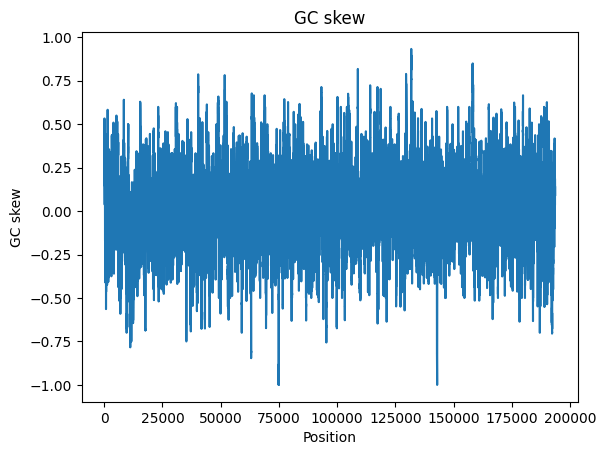

In [24]:
import numpy as np

def gc_skew(seq, window_size=100):
    seq = seq.upper()
    skew = []
    for i in range(0, len(seq) - window_size):
        window = seq[i:i + window_size]
        g = window.count("G")
        c = window.count("C")
        skew.append((g - c) / (g + c + 1e-6))  # 0除算防止
    return skew

skew = gc_skew(record.seq)
plt.plot(skew)
plt.title("GC skew")
plt.xlabel("Position")
plt.ylabel("GC skew")
plt.show()
